In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict,Counter
import matplotlib.pyplot as plt


In [2]:
DATA_DIR = 'data/amazon_des.pkl'

In [3]:
df = pd.read_pickle(DATA_DIR)

In [4]:
df.categories = df.categories.apply(set)
df.head()

,categories,train/test,text
0000025240,"{politics & government, international & world ...",train,"Alan A. Block is emeritus professor of crime, ..."
0001004743,"{classics, children's books, books, literature...",train,Grade 4-8?The law of the jungle?intense compet...
0001024043,"{children's books, books, literature & fiction}",train,Trotter Street is alive with activity! Mae pre...
0001042335,"{new, humanities, used & rental textbooks, eng...",train,William Shakespeare is widely regarded as the ...
0001046349,"{contemporary, books, literature & fiction}",train,"""No matter how appalling, malicious and preten..."


In [5]:
df['train/test'].value_counts()

train    1186239
test      306782
Name: train/test, dtype: int64

# Label distribution

In [6]:
# count +ve instances
labels = defaultdict(int)
for cats in df.categories:
    for cat in cats:
        labels[cat]+=1

In [7]:
l = sorted(zip(labels.values(),labels.keys()))

In [8]:
l[:10]

[(2, '& magic'),
 (2, '( i )'),
 (2, '1945 - present'),
 (2, 'a'),
 (2, 'a-d & d-a converters'),
 (2, 'abrasive collets'),
 (2, 'absorption sleeves'),
 (2, 'acapulco'),
 (2, 'acoustic guitar effects'),
 (2, 'acoustic guitar stands')]

In [9]:
l[-10:]

[(90254, 'new'),
 (90254, 'used & rental textbooks'),
 (94082, 'rock'),
 (96140, 'education & reference'),
 (111261, 'movies'),
 (122606, 'literature & fiction'),
 (150464, 'pop'),
 (160161, 'movies & tv'),
 (243575, 'music'),
 (446881, 'books')]

In [10]:
freqs = np.array(sorted(labels.values(),reverse = True))

91.98% P@1 can be achieved by predicting only 8.02% of classes correctly, ignoring tail labels


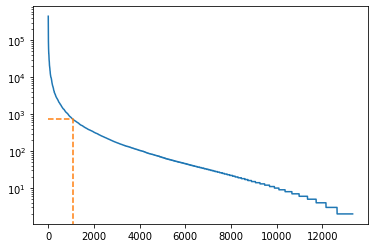

In [11]:
p = 91.98
yy = np.percentile(freqs,91.98)
xx = np.argmax(freqs<=yy)
plt.plot(freqs)
plt.plot([0,xx,xx],[yy,yy,0],'--')
plt.yscale('log')
print('{:.2f}% P@1 can be achieved by predicting only {:.2f}% of classes correctly, ignoring tail labels'.format(p,xx/len(freqs)*100))

# Label hiarachy

In [12]:
CAT_DIR = './Amazon_RawData/categories.txt'
CAT_MAP_DIR = "./AmazonCat-13K_mappings/AmazonCat-13K_label_map.txt"

In [13]:
# read categories
with open(CAT_MAP_DIR,'r',encoding = "ISO-8859-1") as f:
    cats_map = f.read().splitlines()
cats_set = set([c.lower() for c in cats_map])
with open(CAT_DIR,'r',encoding = "ISO-8859-1") as f:
    lines = f.read().splitlines()

In [14]:
data = defaultdict(dict)

In [15]:
invalid = []
for i,line in enumerate(lines):
    if line[0]!=' ':
        id = line
        data[id]['categories']=[]
    elif line[:2]=='  ':
        cats = [t.strip().lower() for t in line.split(',')]
        cats = [c for c in cats if c in cats_set]
        if cats:
            data[id]['categories'].append(cats)
        else:
            invalid.append((i,line))
    else:
        raise Exception('invalide line {} : {}'.format(i,line))
print(set([line for i,line in invalid]))

{'  ', '  Dance & DJ, Trance', '  Dance & DJ, Electronica', '  Amazon MP3 Store'}


In [16]:
# only keep entries within train/test set
d = {key:data[key] for key in df.index.values}
data = d

In [17]:
# number of distinct hiarachy
h = [' > '.join(tag) for entry in data.values() for tag in entry['categories']]
print('No. of distinct hiarachy: {}'.format(len(set(h))))
print('No. of distinct lables  : {}'.format(len(labels)))

No. of distinct hiarachy: 19189
No. of distinct lables  : 13330


In [18]:
# depth of hiarachy
depths = [len(tag) for entry in data.values() for tag in entry['categories']]
depths = np.array(sorted(depths,reverse=True))
print('Depths: mean:{:.2f} min:{} max:{}'.format(np.mean(depths),np.min(depths),np.max(depths)))

Depths: mean:3.37 min:1 max:9


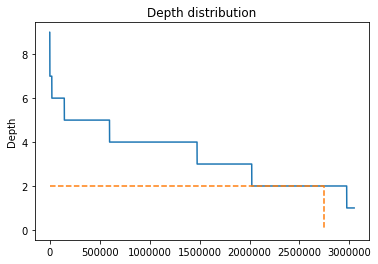

In [19]:
plt.plot(depths)
xx = .9*len(depths)
yy = depths[int(xx)]
plt.plot([0,xx,xx],[yy,yy,0],'--')
plt.title('Depth distribution')
plt.ylabel('Depth')
plt.show()

In [20]:
Counter(depths)

Counter({9: 53,
         8: 581,
         7: 19246,
         6: 125051,
         5: 452816,
         4: 876518,
         3: 547564,
         2: 950838,
         1: 74988})

90% of data has depth more than 1

## get hiarachy

In [21]:
from anytree.importer import DictImporter
from anytree.resolver import Resolver
from anytree import Node, RenderTree

In [22]:
def get_in(ll):
    if not ll:
        return []
    for i,l in enumerate(ll):
        ll[i]['children'] = get_in(list(l['children'].values()))
    return ll

In [23]:
class MyNode(Node):
    separator = ' > '

In [24]:
cats = [set() for _ in range(9)]
for entry in set(h):
    hh = entry.split(' > ')
    for i,t in enumerate(hh):
        cats[i].add(t)
print('Distinct classes in each layer:')
print([len(cat) for cat in cats])
cats = [set() for _ in range(9)]
for entry in set(h):
    hh = entry.split(' > ')
    for i,t in enumerate(hh):
        if i==0:
            cats[i].add(t)
        else:
            cats[i].add(' > '.join(hh[:i+1]))
print('Distinct hiarachy in each layer:')
print([len(cat) for cat in cats])

Distinct classes in each layer:
[45, 363, 2268, 6052, 5300, 1983, 440, 20, 2]
Distinct hiarachy in each layer:
[45, 383, 2715, 7809, 6713, 2326, 482, 21, 2]


In [25]:
nodes = {}
for entry in set(h):
    hh = entry.split(' > ')
    dd = nodes
    for i,t in enumerate(hh):
        if t not in dd.keys():
            dd[t]={'name':t,
                   'count':0,
                   'children':{}}
        dd = dd[t]['children']
ll = list(nodes.values())
ll = get_in(ll)

In [26]:
importer = DictImporter(MyNode)
trees = {l['name']:importer.import_(l) for l in ll}

In [27]:
# get count of each hiarachy
r = Resolver()
for entry in h:
    tt = entry.split(' > ')
    name = tt[0]
    path = ' > '.join(tt[1:])
    r.get(trees[name],path).count+=1

In [28]:
print(list(trees.keys()))

['books', 'arts', 'kindle store', 'patio', 'clothing & accessories', 'automotive', 'sports & outdoors', 'health & personal care', 'home & kitchen', 'musical instruments', 'shoes', 'office products', 'video games', 'beauty', 'industrial & scientific', 'electronics', 'magazine subscriptions', 'pet supplies', 'grocery & gourmet food', 'tools & home improvement', 'baby products', 'software', 'toys & games', 'jewelry', 'watches', 'appliances', 'music', 'collectibles', 'cell phones & accessories', 'office & school supplies', 'purchase circles', 'computers', 'mp3 players & accessories', 'furniture & d&#233;cor', 'gift cards store', 'miscellaneous', 'movies & tv', 'baby', 'home improvement', 'camera & photo', 'all electronics', 'gps & navigation', 'amazon instant video', 'kitchen & dining', 'car electronics']


In [29]:
print(RenderTree(trees['books']))

MyNode(' > books', count=33152)
├── MyNode(" > books > children's books", count=4735)
│   ├── MyNode(" > books > children's books > religions", count=81)
│   │   ├── MyNode(" > books > children's books > religions > hinduism", count=2)
│   │   ├── MyNode(" > books > children's books > religions > christianity", count=211)
│   │   │   ├── MyNode(" > books > children's books > religions > christianity > prayer", count=85)
│   │   │   ├── MyNode(" > books > children's books > religions > christianity > noah's ark", count=27)
│   │   │   ├── MyNode(" > books > children's books > religions > christianity > devotional", count=85)
│   │   │   ├── MyNode(" > books > children's books > religions > christianity > biographies", count=10)
│   │   │   ├── MyNode(" > books > children's books > religions > christianity > bible", count=331)
│   │   │   ├── MyNode(" > books > children's books > religions > christianity > jesus", count=56)
│   │   │   └── MyNode(" > books > children's books > religions 

distribution of each layer in tree

In [31]:
cats = [defaultdict(int) for _ in range(9)]
for entry in h:
    hh = entry.split(' > ')
    for i,t in enumerate(hh):
        if i==0:
            tt=t
        else:
            tt=' > '.join(hh[:i+1])
        cats[i][t]+=1
print('Distinct hiarachy in each layer:')
print([len(cat) for cat in cats])

Distinct hiarachy in each layer:
[45, 363, 2268, 6052, 5300, 1983, 440, 20, 2]


In [64]:
threshold = 50
D = cats[1]
text = True

fig, ax = plt.subplots(figsize=(10, 20))
dd = sorted(zip(D.values(),D.keys()))
if len(dd)>threshold:
    a = threshold//2
    dd = dd[:a]+dd[-a:]
    plt.axhline(y=a-0.5,ls= '--')
counts,labels = zip(*dd)
plt.barh(range(len(counts)), counts, align='center')
plt.yticks(range(len(labels)), labels)
if text:
    for i,count in enumerate(counts):
        plt.text(i,count,str(count))
plt.show()

ValueError: Image size of 740x3655613 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 720x1440 with 1 Axes>

In [44]:
5//2

2